In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:

key = os.environ.get('AZURE_SEARCH_KEY', '01f5c2acf7544c39a6e137ca07e1b452')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128)>

In [5]:
results = search_images_bing(key, 'cardboard box')
ims = results.attrgot('content_url')
len(ims)

150

In [6]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [7]:

dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

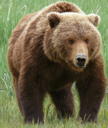

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
waste_types = 'soda can','cardboard box','plastic bottle'
path = Path('waste')

In [10]:
if not path.exists():
    path.mkdir()
    for o in waste_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [11]:
fns = get_image_files(path)
fns

(#433) [Path('waste/cardboard box/00000000.jpg'),Path('waste/cardboard box/00000001.jpg'),Path('waste/cardboard box/00000002.jpg'),Path('waste/cardboard box/00000003.jpg'),Path('waste/cardboard box/00000004.jpg'),Path('waste/cardboard box/00000005.jpg'),Path('waste/cardboard box/00000006.jpg'),Path('waste/cardboard box/00000007.jpg'),Path('waste/cardboard box/00000008.jpg'),Path('waste/cardboard box/00000009.jpg')...]

In [12]:
failed = verify_images(fns)
failed


(#0) []

In [13]:
failed.map(Path.unlink);

In [14]:
waste = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = waste.dataloaders(path)

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


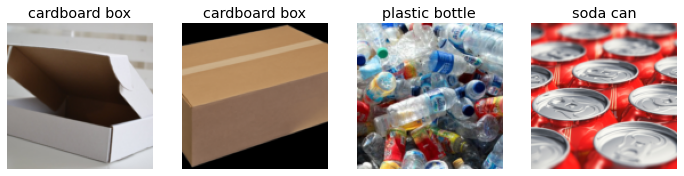

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

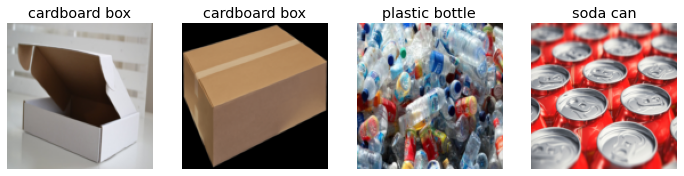

In [17]:
waste = waste.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = waste.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

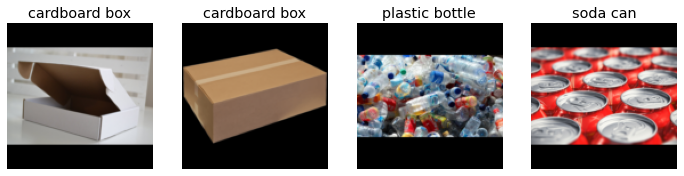

In [18]:
waste = waste.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = waste.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

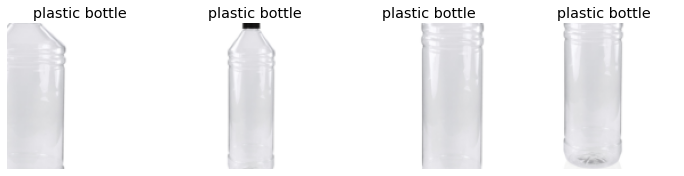

In [19]:

waste = waste.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = waste.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

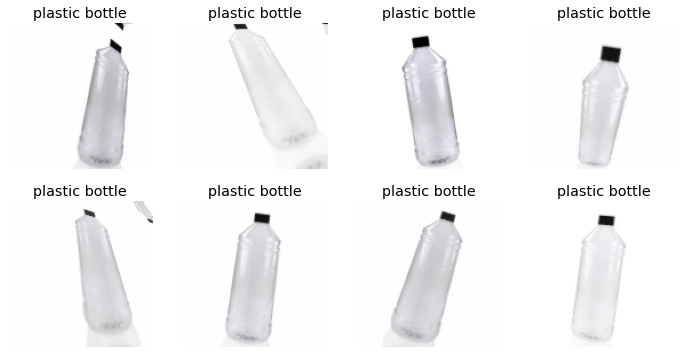

In [20]:
waste = waste.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = waste.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [21]:
waste = waste.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = waste.dataloaders(path)

In [22]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.456849,0.287034,0.104651,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.356350,0.132739,0.069767,00:08
1,0.258054,0.070627,0.023256,00:07
2,0.198267,0.049839,0.023256,00:07
3,0.166486,0.044670,0.023256,00:07


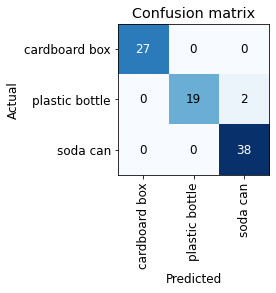

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

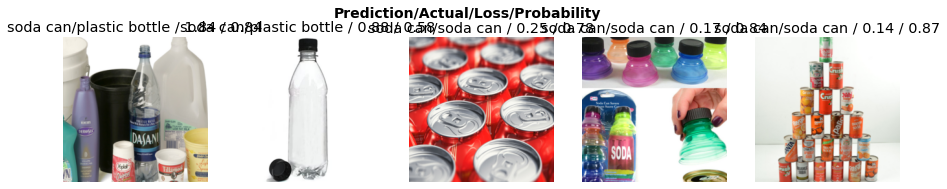

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:

learn.export()

In [27]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [28]:
learn_inf = load_learner(path/'export.pkl')

In [29]:
learn_inf.dls.vocab

(#3) ['cardboard box','plastic bottle','soda can']

In [30]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [31]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [32]:
img = PILImage.create(btn_upload.data[-1])

In [33]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [34]:
pred,pred_idx,probs = learn_inf.predict(img)

In [35]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: soda can; Probability: 0.9504')

In [36]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [37]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [38]:
btn_upload = widgets.FileUpload()

In [42]:
VBox([widgets.Label('Upload your waste!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [41]:
!pip install voila
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.1.23 OK
